In [97]:
import os
import sys
import csv
import gzip
import tqdm

import numpy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

Run Correlations
==

The correlations should be run using a multiprocessing server. There are scripts in src to run that analysis. After that is complete then this script will load and analyze those results

In [36]:
ls ../results/

event_means_correlations_0_10.txt.gz


In [38]:
fn = '../data/project_aers_10q4.pred_drug_events_e5.txt.gz'
wcres = !gzcat $fn | wc -l
nlines = int(wcres[0])
reader = csv.reader(gzip.open(fn), delimiter='\t')
header = reader.next()
#print header

drugs = set()
events = set()

means = defaultdict(dict)

for row in tqdm.tqdm(reader, total=nlines):
    data = dict(zip(header, row))
    drugs.add(data['stitch_id'])
    events.add(data['umls_id'])
    means[data['umls_id']][data['stitch_id']]= float(data['drug_mean'])

events = sorted(events)
drugs = sorted(drugs)

len(events), len(drugs)

100%|█████████▉| 1823954/1823955 [00:18<00:00, 98707.70it/s]


(10437, 1332)

In [78]:
# Load the correlations from file
fn = '../results/event_means_correlations_10410_10757.txt.gz'
reader = csv.reader(gzip.open(fn), delimiter='\t')

correlations = dict()

for e1, e2, r, rp, rho, rhop, n in tqdm.tqdm(reader):
    if e1 == 'umls_id1':
        # header row
        continue
    correlations[(e1,e2)] = (float(rho), float(rhop), int(n))

179432it [00:01, 164963.97it/s]


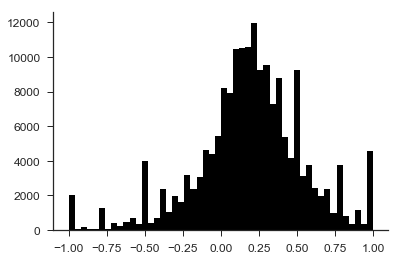

In [79]:
rs, ps, ns = zip(*correlations.values())
sns.set(style='ticks', font_scale=1.2)
plt.hist(rs, bins=50, color='k')
sns.despine()

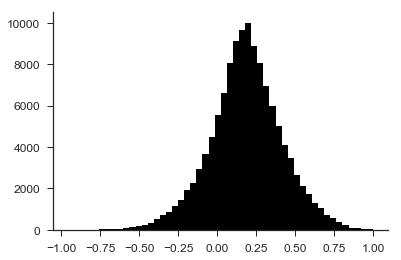

In [80]:
rs, ps, ns = zip(*[(r, p, n) for r, p, n in correlations.values() if n >= 10])
sns.set(style='ticks', font_scale=1.2)
plt.hist(rs, bins=50, color='k')
sns.despine()

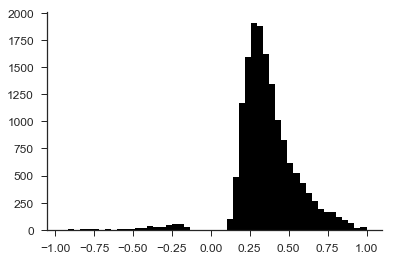

In [82]:
rs, ps, ns = zip(*[(r, p, n) for r, p, n in correlations.values() if p < 0.001 and n >= 10])
sns.set(style='ticks', font_scale=1.2)
plt.hist(rs, bins=50, color='k')
sns.despine()

In [93]:
highly_correlated = [(e1, e2, r, p, n) for (e1, e2), (r, p, n) in correlations.items() if r > 0.5 and p < 0.05 and n > 50]
len(highly_correlated)

978

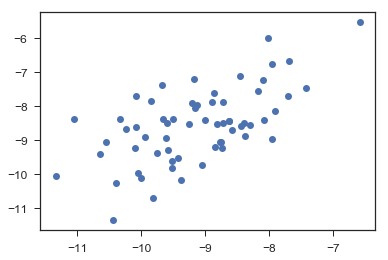

In [98]:
e1, e2, r, p, n = highly_correlated[3]

e1_drugs = set(means[e1].keys())
e2_drugs = set(means[e2].keys())
common_drugs = sorted(e1_drugs & e2_drugs)

x1 = [means[e1][d] for d in common_drugs]
x2 = [means[e2][d] for d in common_drugs]

plt.plot(numpy.log(x1), numpy.log(x2), 'o')